# MNIST_NNET (MNIST Dataset Neural Network Code)

# 0 Set Up

In [1]:
#generate a 128 bit random number as the seed for my random number generation (when initialising parameters)

# import secrets
# secrets.randbits(128)

# here is the one I got
# 136194553992213785217382377961235308297

In [2]:
seed = 136194553992213785217382377961235308297

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math


In [4]:
train_df = pd.read_csv("/Users/wilhelmlannin/Documents/Python Stuff/MNIST_stuff/MNIST_CSV/mnist_train.csv",header=None)
train_df

# each row is a training case
# 0th column tells us the label for the case in that row
# rest of the columns tell us the pixel vals (reading left to right from top left)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# just wanted to verify that these pixel values are between 0 and 255
train_df.iloc[0,1:].describe()

count    784.000000
mean      35.108418
std       79.699674
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      255.000000
Name: 0, dtype: float64

In [6]:
#here i define the lower and upper bounds needed to get each set of 28 pixels that form each row of the image!
# keep adding 28 to 1 until we hit 784
bound=1
bounds_list = []
while bound < 784:
    bound_l = bound
    bound += 28
    bound_u = bound
    bounds_list += [(bound_l,bound_u)]
bounds_list


[(1, 29),
 (29, 57),
 (57, 85),
 (85, 113),
 (113, 141),
 (141, 169),
 (169, 197),
 (197, 225),
 (225, 253),
 (253, 281),
 (281, 309),
 (309, 337),
 (337, 365),
 (365, 393),
 (393, 421),
 (421, 449),
 (449, 477),
 (477, 505),
 (505, 533),
 (533, 561),
 (561, 589),
 (589, 617),
 (617, 645),
 (645, 673),
 (673, 701),
 (701, 729),
 (729, 757),
 (757, 785)]

label: 9


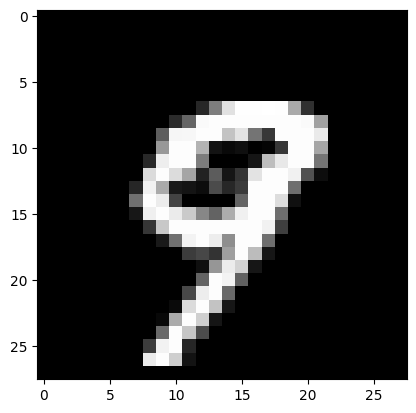

In [7]:

#get pixels of kth image in 28x28 format in array called img
k=87
print("label:",train_df.iloc[k,0])
img = np.array([list(train_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
plt.imshow(img, cmap='gray')
plt.show()


In [8]:
# wrap this in a function so we can see the label and drawn image of any of the k training images
def view_train_image(k):
    print("label:",train_df.iloc[k,0])
    img = np.array([list(train_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
    plt.imshow(img, cmap='gray')
    plt.show()


# 1 Initialise NNet

In [9]:
# need to create all the objects that describe the parameters of the network
# may be worth wrapping in a class? we will see
# also, I'd like to use numpy arrays


## 1.1 Random Number Generation

In [10]:
# set random state in np.random
rng = np.random.default_rng(seed)
# now this function randomly fenerates nums between 0 and 1 according to the seed I have set (for reproduceability)
rng.random()

0.3265827391056191

In [11]:
# can generate arrays with nxm dimensions
rng.random(size=([1,2]))


array([[0.2497092 , 0.15885385]])

In [12]:
#need a function that randomly generates initial values for the parameters
4*rng.random() - 2
#this generates numbers between -2 and 2, I will start with that

-1.204648370637754

In [13]:
#wrap in my own function
def wrand(size=None):
    return 4*rng.random(size=size) - 2

wrand()

-0.4645553837137615

In [14]:
wrand([1,2])

array([[-1.40833147, -0.57100389]])

## 1.2 Initialise Parameters

In [15]:
#number of neurons in each layer
L = {0:784, 1:128, 2:64, 3:10}


In [16]:
#bias vals (randomly initialised)
b = {1:wrand(), 2:wrand(), 3:wrand()}
print(b)


{1: 1.6971597505793126, 2: 1.362263912476521, 3: -0.39469122467489415}


In [17]:
# weight matrices (randomly initialised)
W = {1:wrand(size=[L[0],L[1]]),
     2:wrand(size=[L[1],L[2]]),
     3:wrand(size=[L[2],L[3]])}


In [18]:
W[1].shape

(784, 128)

In [19]:
# now all our parameters are initialised

## 1.3 Try a single prediction

In [20]:
# lets try running our first image through this randomly generated neural network

In [21]:
W[1].shape
# start with matrix multiplication of W[1] with the 784x1 vector that is the image

(784, 128)

In [22]:
# get the 784x1 vector of the kth image
k=0
vec = np.array(train_df.iloc[k,1:]).flatten()
print(vec.size)
print(vec.shape)


784
(784,)


In [23]:
# here is the 0th image... a bunch of pixel values between 0 and 255
vec

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [24]:
# now do the matrix multiplication
vec @ W[1]

array([-2249.46980599,  5103.70621148,  3158.96796707, -1205.59407543,
       -8106.66051858, -2261.95985173, -1877.25618508, -4326.74083757,
         481.95995709, -1235.17194763,   673.94820086,   302.69982739,
       -1927.02633018, -3850.59918319,  3803.67592698,  -541.69138849,
        3160.5810435 ,  2159.98464147, -1319.2569832 ,  -117.69165678,
         876.29094464, -3974.6452943 ,  -618.44068167,  2177.1786375 ,
        4444.75923709,   276.93998349,   477.08630129,  2120.32477124,
       -1272.45882615,  2574.39433638, -4557.39075206,  3379.23200056,
       -2785.86367381,  1797.50227155,   929.53280674,  1523.63355248,
         945.2956367 , -2086.08345714, -3731.0803025 ,  -637.21567858,
       -5255.93055397, -2190.20473144, -3481.92330414,  5322.38582612,
       -2615.35303974,  4171.80589354,    38.89902141,  2359.71965605,
       -5019.89719651,  1705.84211536, -3581.61967924, -1679.52457618,
        2577.4804081 ,  2304.85044601,  3831.86063674, -2277.33959771,
      

In [25]:
# to build on this, we want to add that layer's bias and then apply ReLU elementwise to the whole thing... so do that
(b[1] + (vec @ W[1]))

array([-2247.77264624,  5105.40337123,  3160.66512683, -1203.89691568,
       -8104.96335883, -2260.26269198, -1875.55902533, -4325.04367782,
         483.65711684, -1233.47478787,   675.64536061,   304.39698714,
       -1925.32917043, -3848.90202344,  3805.37308673,  -539.99422874,
        3162.27820325,  2161.68180122, -1317.55982345,  -115.99449703,
         877.98810439, -3972.94813455,  -616.74352192,  2178.87579725,
        4446.45639684,   278.63714324,   478.78346104,  2122.021931  ,
       -1270.7616664 ,  2576.09149613, -4555.69359231,  3380.92916031,
       -2784.16651406,  1799.1994313 ,   931.22996649,  1525.33071223,
         946.99279645, -2084.38629739, -3729.38314275,  -635.51851883,
       -5254.23339422, -2188.50757168, -3480.22614439,  5324.08298587,
       -2613.65587999,  4173.50305329,    40.59618116,  2361.41681581,
       -5018.20003676,  1707.53927512, -3579.92251949, -1677.82741643,
        2579.17756785,  2306.54760576,  3833.55779649, -2275.64243796,
      

In [26]:
#try np.vectorize for applying max([0,x]) ?
def ReLU(x):
    return max([0,x])

# vectorise it, and ensure output type is float so any decimals are retained
f = np.vectorize(ReLU,otypes=[float])

# okay, that worked VERY WELL
f(b[1] + (vec @ W[1]))



array([   0.        , 5105.40337123, 3160.66512683,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        483.65711684,    0.        ,  675.64536061,  304.39698714,
          0.        ,    0.        , 3805.37308673,    0.        ,
       3162.27820325, 2161.68180122,    0.        ,    0.        ,
        877.98810439,    0.        ,    0.        , 2178.87579725,
       4446.45639684,  278.63714324,  478.78346104, 2122.021931  ,
          0.        , 2576.09149613,    0.        , 3380.92916031,
          0.        , 1799.1994313 ,  931.22996649, 1525.33071223,
        946.99279645,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        , 5324.08298587,
          0.        , 4173.50305329,   40.59618116, 2361.41681581,
          0.        , 1707.53927512,    0.        ,    0.        ,
       2579.17756785, 2306.54760576, 3833.55779649,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [27]:
# now carry on this pattern to get the final neuron values in the 3rd layer!
# for each layer, we add the bias to the matrix multiplication of the last layer's neurons, then apply ReLU and REPEAT
f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))

array([ 22359.70679153,      0.        ,      0.        ,  65092.81758966,
        78201.32236168, 278243.59138348,      0.        ,      0.        ,
            0.        ,  23978.45736383])

In [28]:
# vectorize the math.exp function so we can calculate the softmax probabilities using e^
allexp = np.vectorize(math.exp)


In [29]:
# this cell errors, so commenting out

# now calculate the softmax probabilities
# allexp = np.vectorize(math.exp)
# p3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))
# allexp(p3)
# oh no, some numbers must be too big
# to try and stop this, I may divide all the initial pixel values by 255 to limit their vals to [0,1] range


In [30]:
# this cell errors, so commenting out

# divide all the initial pixel values by 255 to limit their vals to [0,1] range
# k=0
# smallvec = np.array(train_df.iloc[k,1:]).flatten() / 255

# smallp3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( smallvec @ W[1] )) @ W[2])) @ W[3]))
# print(smallp3)
# allexp(smallp3)


In [31]:
# this cell errors, so commenting out

# I am thinking of rounding after the decimal place before taking exp, since I only need 3dp at most (probably?)
# allround = np.vectorize(lambda x: round(x,3))
# roundsmallp3 = allround(f(b[3] + ( f(b[2] + ( f(b[1] + ( smallvec @ W[1] )) @ W[2])) @ W[3])))
# print(roundsmallp3)
# allexp(roundsmallp3)
#?

In [32]:
print(math.exp(709))
# print(math.exp(710))  #tried it and 710 seems to be where errors start

8.218407461554972e+307


## 1.4 Xavier Initialisation

In [33]:
# I read about initialising parameter values using Xavier distribution:
# initialise biases as =0
# initialise weights in layer L via normal dist with mean 0 and variance = 1/(num_neurons_in_layer_(L-1))
rng.normal(loc=0,scale=(1/L[0])**0.5)

0.041527442646279326

In [34]:
# can you use normal to return a random ARRAY? YES
rng.normal(loc=0,scale=(1/L[0])**0.5,size=[1,2])


array([[-0.00423504,  0.0115572 ]])

In [35]:
#number of neurons in each layer
L = {0:784, 1:128, 2:64, 3:10}
#bias vals initialised at 0
b = {1:0, 2:0, 3:0}
# weight matrices (randomly initialised using xavier)
W = {1:rng.normal(loc=0,scale=(1/L[0])**0.5,size=[L[0],L[1]]),
     2:rng.normal(loc=0,scale=(1/L[1])**0.5,size=[L[1],L[2]]),
     3:rng.normal(loc=0,scale=(1/L[2])**0.5,size=[L[2],L[3]])}


## 1.5 Prediction with Xavier Init

In [36]:
# divide all the initial pixel values by 255 to limit their vals to [0,1] range
k=0
smallvec = np.array(train_df.iloc[k,1:]).flatten() / 255

smallp3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( smallvec @ W[1] )) @ W[2])) @ W[3]))
print(smallp3)



[0.         0.02928147 0.         0.19179514 0.09803207 0.08261278
 0.         0.         0.20108049 0.01316989]


In [37]:
# now calculate the softmax probabilities
expvec = allexp(smallp3)
phat = expvec/sum(expvec)
phat


array([0.09375378, 0.09653962, 0.09375378, 0.11357543, 0.10341025,
       0.10182797, 0.09375378, 0.09375378, 0.11463492, 0.09499668])

In [38]:
#grab the prediction made by my network (the index of phat containing the largest value)
pred_label = [idx for idx,val in enumerate(phat) if val >= max(phat)][0]
pred_label


8

label: 5


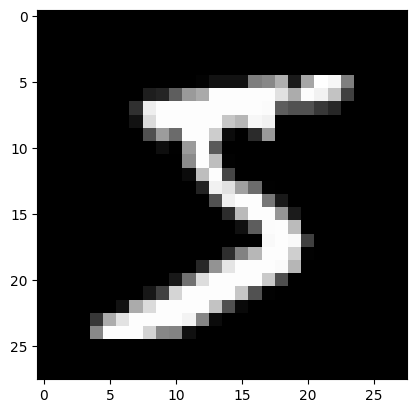

In [39]:
# now look at the image and the true label... was my network correct (I imagine not!)
view_train_image(k)


In [40]:
# also from now on I will use the training image pixel values mapped to the interval [0,1] via this array:
train_arr_01 = np.array(train_df.iloc[:,1:]) / 255
train_arr_01

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

my network prediction: 0
label: 7


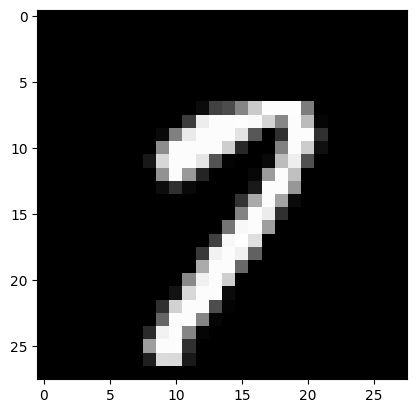

In [41]:
# so, to wrap this section up... here is my code to make a prediction on the kth image (not a good prediction, at that!!)
k=9999
vec = train_arr_01[k]
p3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))
expvec = allexp(p3)
phat = expvec/sum(expvec)
pred_label = [idx for idx,val in enumerate(phat) if val >= max(phat)][0]
print("my network prediction:",pred_label)
view_train_image(k)


In [42]:
# can put my prediction code in one function
def generate_phat_k(k):
    vec = train_arr_01[k]
    p3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))
    expvec = allexp(p3)
    phat = expvec/sum(expvec)
    # pred_label = [idx for idx,val in enumerate(phat) if val >= max(phat)][0]
    return phat

generate_phat_k(13)


array([0.11105736, 0.09716992, 0.09556072, 0.1014054 , 0.10258829,
       0.10143117, 0.09372359, 0.09372359, 0.10961636, 0.09372359])

In [43]:
# can put my prediction code in one function
def predict_k(k):
    vec = train_arr_01[k]
    p3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))
    expvec = allexp(p3)
    phat = expvec/sum(expvec)
    return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]

predict_k(13)

0

In [44]:
# in the next section, we build out the code needed to train the network!!

# 2 Code Needed for Training

In [45]:
# before diving into training, I will play with the code I think we need to do said training of the network

## 2.1 Cost (Cross Entropy Loss)

In [46]:
# I will be using Cross Entropy to quantify the "cost"/"loss" of my network (i.e. how wrong it is)
# calculate the cross entropy loss for the network over ALL training examples
# for the kth training example, add log(phat_j) to the cost (where j is the true label of the kth example)



In [47]:
# so, start by creating a vector t of all the true labels (where element i of this vector will be the true label of example i)
t = np.array(train_df[0])

In [48]:
#for each training example k, find the vector phat_k and then use t to tell us which element to use
log_phats = [math.log(generate_phat_k(idx)[t_val]) for idx,t_val in enumerate(t)]


In [49]:
# now calculate cross entropy loss by summing these log_phats and multiplying by -1/K (where K is the number of training examples)
K = len(t)
cost = (-1/K)*sum([math.log(generate_phat_k(idx)[t_val]) for idx,t_val in enumerate(t)])
print("Cross Entropy Loss =",cost)


Cross Entropy Loss = 2.310810136532411


## 2.2 Performance Measures

In [50]:
# pred_labels = [predict_k(k) for k,t_val in enumerate(t)]i

In [51]:
# is it quicker than 13s vectorized? Yes, a bit
vec_predict = np.vectorize(predict_k)
pred_labels1 = vec_predict(np.array(range(len(t))))


In [52]:
# TOTAL ACCURACY (percent of cases that the model predicted correctly)
true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(t)]
total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
print(total_accuracy)
print("total accuracy =", round(100*total_accuracy,2),"%")


0.07725
total accuracy = 7.72 %


In [53]:
# digit accuracy is the percent of training cases containing digit n that the model predicted correctly
digit_accuracy = {}
for digit in range(10):
    train_cases_containing_digit = [k for k,true_val in enumerate(t) if true_val==digit]
    # now calculate how many of these cases we predicted correctly
    checklist = [pred_labels1[k]==digit for k,true_val in enumerate(train_cases_containing_digit)]
    digit_accuracy[digit] = sum(checklist)/len(checklist)

digit_accuracy
#can see we currently get a lot of 0 cases correct, but this is because 0 is chosen if we encounter a tie

{0: 0.21492486915414485,
 1: 0.026105013349154552,
 2: 0.01544142329640819,
 3: 0.43793834610993315,
 4: 0.09619993153029785,
 5: 0.055524810920494376,
 6: 0.0023656640757012504,
 7: 0.002553870710295291,
 8: 0.1298923260981029,
 9: 0.01781812069255337}

In [54]:
# digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit

digit_recall = {}
for digit in range(10):
    cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
    # now calculate how many of these cases actually contained this digit correctly
    checklist = [t[k]==digit for k,true_val in enumerate(cases_we_predicted_digit)]
    digit_recall[digit] = sum(checklist)/len(checklist)

digit_recall
# weirdly 6 has 0 recall, perhaps we never predicted 6? other than that we see a pretty even spread here... 1 is doing weirdly well

{0: 0.10035814388041109,
 1: 0.11507009345794393,
 2: 0.10186335403726708,
 3: 0.10356740809751175,
 4: 0.10379746835443038,
 5: 0.08957415565345081,
 6: 0.10434782608695652,
 7: 0.1,
 8: 0.0940576011666059,
 9: 0.09962756052141528}

In [55]:
# just checking how much we predicted each digit
pred_counts = {digit:len([k for k,pred in enumerate(pred_labels1) if pred==digit]) for digit in range(10)}
pred_counts
# all are equally low except of course 0 but also 3 stands out as surprisingly high


{0: 12844,
 1: 1712,
 2: 805,
 3: 25761,
 4: 5925,
 5: 3405,
 6: 115,
 7: 130,
 8: 8229,
 9: 1074}

## 2.3 Pre-reqs to Gradient Calculations

In [ ]:
# my derivation for the layer 3 bias gradient has 2 distinct terms in it that we need to calculate for each training case k:
# 1) phat (the vector of softmax probabilities)
# 2) layer 3 weight sums i.e. the value at each neuron in layer 3 BEFORE applying activation function ReLU


In [57]:
# 1) phat (the vector of softmax probabilities)
phat_all_k = np.array([generate_phat_k(k) for k in range(len(t))])


In [58]:
# 2) layer 3 weight sums i.e. the value at each neuron in layer 3 BEFORE applying activation function ReLU
k=8  #doing this calculation for one training case here
weightsums_3 = b[3] + ( f(b[2] + ( f(b[1] + ( train_arr_01[k] @ W[1] )) @ W[2])) @ W[3])
weightsums_3


array([ 0.16143577, -0.17386073,  0.06627675, -0.0677996 ,  0.10667387,
        0.02265627, -0.03565025, -0.09097051,  0.05963224, -0.07038977])

### Idea: 1 pass through network?

In [ ]:
# just having a thought while I code this... since we eventually are going to need all the weight sums from each layer AND THEN the phat...
#...vectors, we should try to minimise how much we make python recalculate the same thing over and over again. So, can I...
#...take the weight sums etc that I need during one single pass throught the network, going step by step until final step of phat?


In [ ]:
# we need every single weight sum for every single k, so create a data structure that allows us to store these conveniently

#defining this dictionary is making me think about having a 3d numpy array where the dimensions are:
# layer l, training case K, and the neurons (in layer l there are L[l] many)
wsums = {l:{} for l in L.keys()}

wsums[1] = {k:b[1] + (train_arr_01[k] @ W[1]) for k in range(len(t))}
# now we need to define the second layer weight sums using wsums[1]
wsums[2] = {k:b[2] + f(wsums[1][k]) @ W[2] for k in range(len(t))}
# and define the 3rd layer weight sums using the second weight sums we just calculated
wsums[3] = {k:b[3] + f(wsums[2][k]) @ W[3] for k in range(len(t))}
#this way, we get all the weight sums we need and only have to do each matrix multiplication once! work samrter not harder?

# original formula here for reference
# f(b[3] + ( f(b[2] + ( f(b[1] + ( train_arr_01[k] @ W[1] )) @ W[2])) @ W[3]))


In [511]:
train_arr_01.shape

(60000, 784)

In [77]:
# now we need to arrive at phat for each training case k from the layer 3 weightsums in wsums[3]
expvec_all_k = [allexp(f(wsums[3][k])) for k in range(len(t))]
phat_all_k = [expvec_all_k[k]/sum(expvec_all_k[k]) for k in range(len(t))]
print("example of phat for the 0th training case:",phat_all_k[0])


example of phat for the 0th training case: [0.09375378 0.09653962 0.09375378 0.11357543 0.10341025 0.10182797
 0.09375378 0.09375378 0.11463492 0.09499668]


In [ ]:
#now we have all this, can easily calculate the gradients with respect to each parameter (see following sections)

## 2.4 Gradient Calculations

In [ ]:
# I have derived formulas for the gradients needed separately, see attached material hopefully (upload a PDF future Will?)
# Here I will simply implement those calculations and hope they're correct

### 2.4.1 Bias Gradients

In [80]:
#create a copy of the bias parameters with a g on the front to signify gradients
g_b = b.copy()
g_b

{1: 0, 2: 0, 3: 0}

In [88]:
# g_b[3] = 

# for training case k, let m be the true label. We need the mth weight sum at layer 3
k=8
print(wsums[3][k])
print(wsums[3][k][t[k]])

# we calculate an indicator that equals 1 if this value is >0, and 0 otherwise
print("indicator:",wsums[3][k][t[k]] > 0)

# now we want to sum the following: for every single digit z from 0 to 9 in layer 3, find this indicator multiplied by the zth element of phat
#I am going to be cheeky and instead only return the non-zero elements of this sum (so I use an "if" to do this)
print()
print(phat_all_k[k])
[phat_all_k[k][z] for z in range(L[3]) if wsums[3][k][z] > 0]
#notice that we only retained the elements of phat that had a positive weight sum - noice


[ 0.16143577 -0.17386073  0.06627675 -0.0677996   0.10667387  0.02265627
 -0.03565025 -0.09097051  0.05963224 -0.07038977]
-0.1738607257478075
indicator: False

[0.11255973 0.09577946 0.1023425  0.09577946 0.10656149 0.09797424
 0.09577946 0.09577946 0.10166474 0.09577946]


[0.11255973294529902,
 0.10234249934473547,
 0.10656148572176075,
 0.09797423573139616,
 0.10166473778993206]

In [90]:
# with all the above pieces in play, we calculate the gradient of the cost function wrt the 3rd bias like so:
g_b[3] = -sum([(wsums[3][k][t[k]] > 0) - sum([phat_all_k[k][z] for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K
print("gradient of the cost function wrt the 3rd bias =",g_b[3])


gradient of the cost function wrt the 3rd bias = 0.056731498034807606


In [140]:
# now things get hairier with the 2nd bias so let me build up my calculation in this cell
k=8
#first, sum all the weights w_i_m in W[3] for which the ith weightsum in layer 2 is >0 AND the mth weightsum in...
#  layer 3 is >0 AND m is the correct label for this training case.
# I have realised we can bring the if outside the loop, so I have done that below too
weights_to_sum = [W[3][i][t[k]] for i in range(L[2]) if wsums[2][k][i] > 0] if wsums[3][k][t[k]] > 0 else []
print("weights_to_sum:",weights_to_sum)
print(f"notice the above list is empty because {wsums[3][k][t[k]]} is not positive")
weightsum = (sum([W[3][i][t[k]] for i in range(L[2]) if wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0)
print("weightsum:",weightsum)

# then the second thing to calculate is a sum over all digits z between 0 and 9 which involves phat (similar to b[3] gradient calculation!)
#the inner sum is the same as the sum above but with the condition on m equalling the correct label relaxed, so all labels z contribute!
values_to_sum_over_z = [phat_all_k[k][z]*sum([W[3][i][z] for i in range(L[2]) if wsums[2][k][i] > 0 and wsums[3][k][z] > 0]) for z in range(L[3])]
print("values_to_sum_over_z:",values_to_sum_over_z)
print("same thing? except 0s, which contribute nothing to sums",[phat_all_k[k][z]*sum([W[3][i][z] for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0])
# it is more efficient to pull the "if wsums[3][k][z] > 0" out of the innermost list comprehension, so I use this approach below!
#now combine these elements in the next cell


weights_to_sum: []
notice the above list is empty because -0.1738607257478075 is not positive
weightsum: 0
values_to_sum_over_z: [0.09885440322507436, 0.0, 0.030838473043653288, 0.0, 0.02779059218521728, 0.031198453341450817, 0.0, 0.0, 0.06624207669169925, 0.0]
same thing? except 0s, which contribute nothing to sums [0.09885440322507436, 0.030838473043653288, 0.02779059218521728, 0.031198453341450817, 0.06624207669169925]


In [138]:
g_b[2] = -sum([(sum([W[3][i][t[k]] for i in range(L[2]) if wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0) \
- sum([phat_all_k[k][z]*sum([W[3][i][z] for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K
print("gradient of the cost function wrt the 2nd bias =",g_b[2])
# took 4.4s to work this one out, I dread to think how long the deeper calculations will take!!


gradient of the cost function wrt the 2nd bias = 0.05089663755853589


In [141]:
#start calculating 1st layer bias gradient for example case k=8
k=8
#similar to the last bias but we squeeze another sum within this term, over j in range(L[1]) i.e. over all 128 neurons in layer 1.
#the elements of this sum are products of weight (i,m) in layer 3 and weight (j,i) in layer 2 (where m is the true label for this training case)
weightproducts_to_sum = [W[3][i][t[k]]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if 
                          wsums[2][k][i] > 0] if wsums[3][k][t[k]] > 0 else []
print("weights_to_sum:",weights_to_sum)
print(f"once again the above list is empty because {wsums[3][k][t[k]]} is not positive")
actualsum = (sum([W[3][i][t[k]]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if 
                          wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0)
print("actualsum:",actualsum)

#now similar to the second sum we've had to do in each other bias gradient, we have a product of phat and some weights summed over every digit z
# I am realising the ifs should not be part of one single if statement, since it may be more efficient to pull each if out as far as they can go
values_to_sum_over_z = [phat_all_k[k][z]*sum([W[3][i][z]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0]
values_to_sum_over_z


weights_to_sum: []
once again the above list is empty because -0.1738607257478075 is not positive
actualsum: 0


[0.03725902839667246,
 0.005408002096197179,
 0.06130519629868697,
 -0.04060157525747576,
 0.033798659096650994]

In [ ]:
g_b[1] = -sum([(sum([W[3][i][t[k]]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0) \
- sum([phat_all_k[k][z]*sum([W[3][i][z]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K
print("gradient of the cost function wrt the 1st bias =",g_b[1])
# took 4m7s, do-able


gradient of the cost function wrt the 1st bias = 0.004083139634485991


In [ ]:
# can we speed this calculation up?

In [ ]:
g_b[1] = -sum(
[
    (
        sum(
            [W[3][i][t[k]]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0])
              for i in range(L[2]) if wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0) \
- sum([phat_all_k[k][z]*sum([W[3][i][z]*sum([W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]) for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K



In [457]:
# focus on cracking this inner part
k=9
sum(
    [
        W[3][i][t[k]] * sum(
            [W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]
                )
    for i in range(L[2]) if wsums[2][k][i] > 0]
              ) if wsums[3][k][t[k]] > 0 else 0

0.6243467772871342

In [468]:
L[2]

64

In [461]:
k=9
#remove the need for i in range(L[2]) if wsums[2][k][i] > 0 by using this condition as an indexer for the i index
i_index = np.nonzero(wsums[2][k][:] > 0)
print(i_index)

# do the same for j index: for j in range(L[1]) if wsums[1][k][j] > 0
j_index = np.nonzero(wsums[1][k][:] > 0)
print(j_index)


(array([ 1,  3,  4,  5,  7,  8, 20, 21, 23, 28, 29, 31, 32, 33, 34, 37, 42,
       43, 44, 45, 46, 47, 52, 54, 56, 57, 58, 61, 62, 63]),)
(array([  2,   4,   6,   7,   8,  11,  17,  19,  20,  21,  24,  25,  26,
        28,  29,  35,  37,  39,  41,  43,  45,  48,  49,  50,  52,  60,
        61,  63,  64,  67,  68,  69,  70,  71,  75,  76,  77,  78,  79,
        81,  82,  83,  85,  87,  92,  95,  98,  99, 103, 105, 110, 115,
       118, 119, 120, 122, 127]),)


In [476]:
print(W[3][i_index,t[k]].shape)
W[3][i_index,t[k]]

(1, 30)


array([[-0.01320224,  0.06662953,  0.05664409,  0.04361186,  0.27119871,
        -0.04032074, -0.00497303,  0.0414925 ,  0.13860661,  0.18963525,
        -0.04283642,  0.0381924 ,  0.08085448,  0.01796495, -0.00211413,
         0.20442345, -0.06653222,  0.05380364, -0.01719256, -0.07097498,
        -0.05909686, -0.13569812,  0.00208287,  0.01806047, -0.2048839 ,
         0.22983924, -0.07905968, -0.01978598, -0.01899574, -0.09383732]])

In [473]:
print(W[2][j_index][:,i_index].shape)
W[2][j_index][:,i_index]

(57, 1, 30)


array([[[ 0.0993001 ,  0.08975795, -0.05275159, ...,  0.01211506,
          0.1806115 ,  0.0071188 ]],

       [[-0.17934181,  0.05593696, -0.01330883, ...,  0.15451894,
         -0.06750442, -0.01139237]],

       [[ 0.02449313, -0.03710994,  0.07248845, ..., -0.0011383 ,
          0.00813584,  0.12102853]],

       ...,

       [[-0.02199665,  0.03454335,  0.03133997, ..., -0.08159778,
          0.04234261, -0.16050193]],

       [[ 0.11416512,  0.10091481, -0.08363767, ...,  0.24280997,
         -0.00391684, -0.09063259]],

       [[ 0.13360259,  0.08682506,  0.09803333, ..., -0.05085488,
         -0.00553527, -0.06382721]]])

In [478]:
# the sum we multiply by is supposed to be summed over j, so try np.sum over j
print(np.sum(W[2][j_index][:,i_index],initial=0,axis=0).shape)
np.sum(W[2][j_index][:,i_index],initial=0,axis=0)

(1, 30)


array([[ 0.32809016,  0.62214971, -0.04945722,  0.47466477,  1.16584501,
         0.01494799,  0.14210468,  0.112388  ,  0.36377631,  0.09531187,
        -0.28786522,  0.08700248,  1.79403064,  0.19141931,  0.72798707,
         0.29719565,  0.07563587, -0.50234687,  1.2375092 ,  0.08551817,
         1.06929207, -0.9066226 ,  0.17910953,  0.20931509,  0.56108266,
         0.1266011 , -0.99483566,  0.62884737,  0.92327345,  0.10079154]])

In [479]:
# now try multiplying together the (1,30) shape arrays we have arrived at
np.multiply(W[3][i_index,t[k]] , np.sum(W[2][j_index][:,i_index],initial=0,axis=0))

array([[-0.00433153,  0.04145354, -0.00280146,  0.02070101,  0.31617566,
        -0.00060271, -0.00070669,  0.00466326,  0.0504218 ,  0.01807449,
         0.01233111,  0.00332283,  0.14505541,  0.00343884, -0.00153906,
         0.06075376, -0.00503222, -0.02702809, -0.02127596, -0.00606965,
        -0.0631918 ,  0.12302698,  0.00037306,  0.00378033, -0.1149568 ,
         0.0290979 ,  0.07865139, -0.01244236, -0.01753826, -0.00945801]])

In [483]:
# so could we reduce it down to something like this? but we need to ensure the indices align
k = 8
np.sum(
        np.multiply(W[3][i_index,t[k]] , np.sum(W[2][j_index][:,i_index],initial=0,axis=0))
              ) if wsums[3][k][t[k]] > 0 else 0

0

In [ ]:
eps = 0.000001
for k in range(1000):

    oldway = sum(
        [
            W[3][i][t[k]] * sum(
                [W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]
                    )
        for i in range(L[2]) if wsums[2][k][i] > 0]
                ) if wsums[3][k][t[k]] > 0 else 0

    newway = np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),t[k]] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][t[k]] > 0 else 0
    if oldway - newway > eps:
        print(k)
# yay the new way is correct

In [ ]:
# lets use this new way for all z terms now too (not just when z is t[k])

In [490]:
# here is the z-dependent-side of the original code I had for bias layer 1 gradient calculation:
k=9
oldz = sum(
    [
        phat_all_k[k][z]*sum(
            [
                W[3][i][z]*sum(
                    [
                        W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]
                        ) for i in range(L[2]) if wsums[2][k][i] > 0]
                        ) for z in range(L[3]) if wsums[3][k][z] > 0])  #for k in range(len(t))]) / K



In [491]:
newz = sum(
    [
        phat_all_k[k][z]*(np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),z] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][z] > 0 else 0) for z in range(L[3]) if wsums[3][k][z] > 0]) 

In [ ]:
eps = 0.000001
for k in range(1000):

    oldz = sum(
    [
        phat_all_k[k][z]*sum(
            [
                W[3][i][z]*sum(
                    [
                        W[2][j][i] for j in range(L[1]) if wsums[1][k][j] > 0]
                        ) for i in range(L[2]) if wsums[2][k][i] > 0]
                        ) for z in range(L[3]) if wsums[3][k][z] > 0])  #for k in range(len(t))]) / K



    newz = sum(
    [
        phat_all_k[k][z]*(np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),z] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][z] > 0 else 0) for z in range(L[3]) if wsums[3][k][z] > 0]) 
    if oldz - newz > eps:
        print(k)
# yay the new way is correct!

In [493]:
%%time
g_b1_fast = -sum(
    [
        (
            np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),t[k]] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][t[k]] > 0 else 0) \

- sum(
    [
        phat_all_k[k][z]*(np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),z] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][z] > 0 else 0) for z in range(L[3]) if wsums[3][k][z] > 0]
                ) for k in range(len(t))]) / K

print("gradient of the cost function wrt the 1st bias =",g_b[1])
print("fast calculation got this value:",g_b1_fast)
#woooooo down from 4 minutes to 6 seconds

gradient of the cost function wrt the 1st bias = 0.004083139634485991
fast calculation got this value: 0.004083139634485993
CPU times: user 6.64 s, sys: 69.9 ms, total: 6.71 s
Wall time: 6.88 s


In [494]:
%%time
g_b[1] = -sum(
    [
        (
            np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),t[k]] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][t[k]] > 0 else 0) \

- sum(
    [
        phat_all_k[k][z]*(np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),z] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][z] > 0 else 0) for z in range(L[3]) if wsums[3][k][z] > 0]
                ) for k in range(len(t))]) / K

print("gradient of the cost function wrt the 1st bias =",g_b[1])

gradient of the cost function wrt the 1st bias = 0.004083139634485993
CPU times: user 6.68 s, sys: 15.2 ms, total: 6.7 s
Wall time: 6.85 s


### 2.4.2 Weight Gradients

In [ ]:
# I have derived the gradients for a general weight at location (alpha,beta) on paper. I will use a as alpha, b as beta in this code.
# lets begin with weights in layer 3 and work our way backwards to arrive at gradients for every single weight


#### Layer 3 Weights

In [148]:
# for W[3], we are using a in range(L[2]) and b in range(L[3]) to pull out the weight W[3][a][b]
print(W[3].shape)
print("weight in 3rd layer at position (a=63,b=9):",W[3][63][9])


(64, 10)
weight in 3rd layer at position (a=63,b=9): -0.10437290387609338


In [166]:
W[3]

array([[-9.87447938e-04,  1.45452182e-01,  2.26306590e-01,
        -3.92453681e-02,  2.25063160e-01, -1.21180300e-01,
         2.87275692e-02,  6.26622195e-02,  6.45229307e-02,
        -2.32097862e-01],
       [-2.42870171e-01,  9.99865252e-02, -6.49397240e-02,
         1.58056115e-02, -1.32022422e-02,  4.47440518e-02,
         5.38091780e-03, -1.99428810e-01,  3.62763557e-02,
        -1.93576732e-01],
       [ 2.07985845e-01, -4.95418253e-02,  1.77876684e-01,
         1.36737981e-01,  1.20648523e-01, -6.98344926e-02,
        -2.88498330e-01,  7.35755868e-02,  2.25617212e-01,
         2.73680122e-01],
       [-4.40760192e-02,  2.58952729e-01,  5.73080939e-02,
         2.64734152e-01,  6.66295265e-02,  7.25002158e-02,
         5.88195958e-02, -4.60838914e-02,  1.74546725e-01,
         2.52758435e-01],
       [-4.37921823e-02,  1.27994671e-01, -1.20271490e-01,
        -4.48291234e-03,  5.66440854e-02,  8.81803536e-02,
         1.68375231e-01, -9.18308849e-02, -5.01334237e-02,
        -9.

In [162]:
k=8
a=63
b=9
# for the W[3][a][b] weight gradient, we need the weightsum in layer 3 going into neuron b:
print("weightsum in layer 3 going into neuron b:",wsums[3][k][b])

# and we need the value of neuron a in layer 2 (i.e. with our activation function - ReLU - applied)
print("value of neuron a in layer 2:",f(wsums[2][k])[a])

# so the element of the sum that comes from training case k for the weight in layer 3 at position (a,b) is the following:
sum_element_a_b_k = (wsums[3][k][b] > 0)*f(wsums[2][k])[a] * ( (b==t[k]) - phat_all_k[k][b] )
print(sum_element_a_b_k)

# there must be a cleverer way to approach this than calculating each weight's gradient one by one... I want to do it for all (a,b) in one!
# 


weightsum in layer 3 going into neuron b: -0.070389767775114
value of neuron a in layer 2: 0.1013068605425941
-0.0


In [165]:
print(wsums[3][k] > 0)
print(f(wsums[2][k]))

[ True False  True False  True  True False False  True False]
[0.         0.13139059 0.         0.         0.         0.07128883
 0.         0.33769119 0.16523399 0.         0.         0.
 0.01933263 0.         0.         0.07821427 0.         0.20319932
 0.         0.         0.08602779 0.0321179  0.00512933 0.16903575
 0.01273482 0.13141736 0.         0.         0.22408648 0.12734374
 0.         0.         0.04231384 0.         0.1189067  0.
 0.14082017 0.01026166 0.00609227 0.12231907 0.         0.10184215
 0.11416016 0.         0.         0.0361915  0.00926809 0.
 0.01697181 0.         0.01751762 0.         0.0787959  0.
 0.         0.         0.         0.         0.14843978 0.1922957
 0.16206729 0.15228808 0.         0.10130686]


In [169]:

dot = np.transpose(wsums[3][k] > 0) @ f(wsums[2][k])
dot

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 10)

In [187]:
#dot product gets us the term (a,b) at the [b][a] index:
dotted = np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2)
print(dotted.shape)
#perfect, now we just need to multiply this by ( (b==t[k]) - phat_all_k[k][b] ) for each corresponding b value... lets do with matrices!
dotted

(10, 64)


array([[0.        , 0.13139059, 0.        , 0.        , 0.        ,
        0.07128883, 0.        , 0.33769119, 0.16523399, 0.        ,
        0.        , 0.        , 0.01933263, 0.        , 0.        ,
        0.07821427, 0.        , 0.20319932, 0.        , 0.        ,
        0.08602779, 0.0321179 , 0.00512933, 0.16903575, 0.01273482,
        0.13141736, 0.        , 0.        , 0.22408648, 0.12734374,
        0.        , 0.        , 0.04231384, 0.        , 0.1189067 ,
        0.        , 0.14082017, 0.01026166, 0.00609227, 0.12231907,
        0.        , 0.10184215, 0.11416016, 0.        , 0.        ,
        0.0361915 , 0.00926809, 0.        , 0.01697181, 0.        ,
        0.01751762, 0.        , 0.0787959 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.14843978, 0.1922957 ,
        0.16206729, 0.15228808, 0.        , 0.10130686],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0. 

In [186]:
#here is code for the vector we want to multiply the above matrix by
print(f"true label for case k={k} is {t[k]}, so we see element 1 comes out biggest in vector below")
[( (b==t[k]) - phat_all_k[k][b] ) for b in range(L[3])]
#we need the b element of this vector to multiply all b-related elements in the above matrix

true label for case k=8 is 1, so we see that comes out biggest in calculation below


[-0.11255973294529902,
 0.9042205383066246,
 -0.10234249934473547,
 -0.09577946169337533,
 -0.10656148572176075,
 -0.09797423573139616,
 -0.09577946169337533,
 -0.09577946169337533,
 -0.10166473778993206,
 -0.09577946169337533]

In [193]:
#try making a 10x10 version of the vector above, where column b contains the same b-related value 10 times
tenten = np.array([[( (b==t[k]) - phat_all_k[k][b] ) for b in range(L[3])] for _ in range(L[3])])
print(tenten)



[[-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]
 [-0.11255973  0.90422054 -0.1023425  -0.09577946 -0.10656149 -0.09797424
  -0.09577946 -0.09577946 -0.10166474 -0.09577946]


In [195]:
#now try matrix multiplication to result in a 10x64 matrix with all the elements of our weightsum for training case k that we need
tenten @ dotted


array([[ 0.        , -0.06846799,  0.        ,  0.        ,  0.        ,
        -0.0371488 ,  0.        , -0.17597179, -0.08610388,  0.        ,
         0.        ,  0.        , -0.01007429,  0.        ,  0.        ,
        -0.04075767,  0.        , -0.10588772,  0.        ,  0.        ,
        -0.04482931, -0.01673673, -0.00267291, -0.08808499, -0.00663615,
        -0.06848194,  0.        ,  0.        , -0.11677207, -0.06635917,
         0.        ,  0.        , -0.02204985,  0.        , -0.0619626 ,
         0.        , -0.07338177, -0.00534738, -0.0031747 , -0.0637408 ,
         0.        , -0.05307022, -0.05948917,  0.        ,  0.        ,
        -0.01885949, -0.00482963,  0.        , -0.00884406,  0.        ,
        -0.00912848,  0.        , -0.04106076,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.07735237, -0.10020581,
        -0.0844537 , -0.07935773,  0.        , -0.05279128],
       [ 0.        , -0.06846799,  0.        ,  0.        ,  0.

In [198]:
#compare the element of this relating to weight (a,b) vs the calculation we did for (a,b) earlier
k=8
a=63
b=9 

#method 1
sum_element_a_b_k = (wsums[3][k][b] > 0)*f(wsums[2][k])[a] * ( (b==t[k]) - phat_all_k[k][b] )
print("method 1:",sum_element_a_b_k)

#method 2
print("method 2:",(tenten @ dotted)[b][a])

method 1: -0.0
method 2: -0.05279127769951657


In [206]:
#debug what is going on inside the matrix multiplications (this is the one to make dotted)
print(np.transpose(np.array(wsums[3][k] > 0,ndmin=2))[b][0])
print(np.array(f(wsums[2][k]),ndmin=2)[0][a])
np.transpose(np.array(wsums[3][k] > 0,ndmin=2))[b][0] * np.array(f(wsums[2][k]),ndmin=2)[0][a]

False
0.1013068605425941


0.0

In [207]:
#this is 0, so our corresponding element of the final matrix should also have been 0... my matrix multiplication is wrong!
#if this is 0 I need the next matrix along in the calculation to show a 0
dotted[b][a]


0.0

In [210]:
#I have realised my mistake... I need element-wise multiplication, not matrix multiplication. So, I need to use a 10x64 matrix
ten64 = np.array([[( (b==t[k]) - phat_all_k[k][b] ) for _ in range(L[2])] for b in range(L[3])])
print(ten64.shape)
ten64

(10, 64)


array([[-0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973, -0.11255973,
        -0.11255973, -0.11255973, -0.11255973, -0.11255973],
       [ 0.90422054,  0.90422054,  0.90422054,  0.90422054,  0.

In [215]:
#compare the element of this relating to weight (a,b) vs the calculation we did for (a,b) earlier
k=9
a=63
b=9 

#method 1
sum_element_a_b_k = (wsums[3][k][b] > 0)*f(wsums[2][k])[a] * ( (b==t[k]) - phat_all_k[k][b] )
print("method 1:",sum_element_a_b_k)

#method 2
dotted = np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2)
ten64 = np.array([[( (b==t[k]) - phat_all_k[k][b] ) for _ in range(L[2])] for b in range(L[3])])
print("method 2 revisited:",np.multiply(ten64,dotted)[b][a])

#done, they match!

method 1: -0.02379698186227527
method 2 revisited: -0.02379698186227527


In [231]:
#so, now we have what we need to define the matrix of gradients for 3rd layer weights, see below

# first make a copy of W that we will store the corresponding gradients in
g_W = W.copy() 


In [227]:
# get familiar with np.sum using the first 3 training cases
first3 = np.array([np.multiply(np.array([[( (b==t[k]) - phat_all_k[k][b] ) for _ in range(L[2])] for b in range(L[3])]),np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2)) for k in range(3)])
np.sum(first3,axis=0).shape
#this must be the correct sum since the shape comes out as desired


(10, 64)

In [232]:
#we should transpose the final answer so that the dimension matches the original weight matrix
W[3].shape

(64, 10)

In [233]:
# now we have what we need to define the matrix of gradients for 3rd layer weights
g_W[3] = np.transpose(-np.sum(np.array([np.multiply(np.array([[( (b==t[k]) - phat_all_k[k][b] ) for _ in range(L[2])] for b in range(L[3])]),np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2))
                            for k in range(len(t))]),axis=0) / K)
print("matrix of gradients relating to layer 3 weights has shape:",g_W[3].shape)
print("element a=L[2]-1,b=L[3]-1 has value:",g_W[3][L[2]-1][L[3]-1])



matrix of gradients relating to layer 3 weights has shape: (64, 10)
element a=L[2]-1,b=L[3]-1 has value: -0.002586417254026912


In [499]:
b=8
np.array([( (b==t[k]) - phat_all_k[k][b] ) for _ in range(L[2])]).shape

(64,)

In [500]:
b=8
np.repeat([( (b==t[k]) - phat_all_k[k][b] )],repeats=L[2]).shape

(64,)

In [503]:
gW3_fast = np.transpose(-np.sum(np.array([np.multiply(np.array([np.repeat([( (b==t[k]) - phat_all_k[k][b] )],repeats=L[2]) for b in range(L[3])]),np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2))
                            for k in range(len(t))]),axis=0) / K)

In [504]:
# this new approach is faster and equals the same, so lets use it below
np.allclose(g_W[3],gW3_fast)

True

In [505]:
g_W[3] = np.transpose(-np.sum(np.array([np.multiply(np.array([np.repeat([( (b==t[k]) - phat_all_k[k][b] )],repeats=L[2]) for b in range(L[3])]),np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2))
                            for k in range(len(t))]),axis=0) / K)

print("matrix of gradients relating to layer 3 weights has shape:",g_W[3].shape)
print("element a=L[2]-1,b=L[3]-1 has value:",g_W[3][L[2]-1][L[3]-1])


matrix of gradients relating to layer 3 weights has shape: (64, 10)
element a=L[2]-1,b=L[3]-1 has value: -0.002586417254026912


#### Layer 2 Weights

In [242]:
# now for the second layer weights. I will try to re-use the approach used for the 3rd layer weights, calculating the entire matrix at once!

#recall we made "dotted" by dot-producting a vector of b-indexed "weightsum>0 indicators" with a vector of a-indexed neurons
# the difference now is that b-index is layer 2 and a-index is layer 1
weightsum_inds = np.transpose(np.array(wsums[2][k] > 0,ndmin=2))
neurons = np.array(f(wsums[1][k]),ndmin=2)
new_dotted = weightsum_inds @ neurons
print(new_dotted.shape)


(64, 128)


In [ ]:
# now the analogue in this layer-2-weight setting to the "ten64" matrix from the layer-3-weights is quite different! We need to...
# multiply the vector of all weights going into layer 3's neuron t[k] by this scalar (boolean) value: wsums[2][k][t[k]] > 0
i3W3_method1 = np.array([W[3][b][t[k]] for b in range(L[2])]) * (wsums[3][k][t[k]] > 0)
#however this is wasteful, since the scalar is boolean so we can avoid doing any of these multiplications by checking if is is true or false once
i3W3_method2 = np.array([W[3][b][t[k]] for b in range(L[2])] if (wsums[3][k][t[k]] > 0) else [0 for _ in range(L[2])])
i3W3_method2
#next we need to do a similar thing but rather than do it for only the true label t[k], we do it for all digits z in range(L[3])

array([ 0.22506316, -0.01320224,  0.12064852,  0.06662953,  0.05664409,
        0.04361186, -0.07365056,  0.27119871, -0.04032074,  0.00521193,
       -0.02786804,  0.07404609,  0.06573815,  0.04252989,  0.11258514,
        0.05828705,  0.10500989,  0.00038964, -0.0627249 , -0.0589155 ,
       -0.00497303,  0.0414925 , -0.0845237 ,  0.13860661, -0.00669105,
       -0.10344819, -0.04837171,  0.03235106,  0.18963525, -0.04283642,
       -0.11994207,  0.0381924 ,  0.08085448,  0.01796495, -0.00211413,
        0.0651553 ,  0.02017011,  0.20442345,  0.10774246,  0.04763767,
        0.01470832,  0.24976151, -0.06653222,  0.05380364, -0.01719256,
       -0.07097498, -0.05909686, -0.13569812, -0.17382059, -0.10453212,
       -0.22140107,  0.01524832,  0.00208287, -0.15880023,  0.01806047,
        0.08674402, -0.2048839 ,  0.22983924, -0.07905968, -0.07614171,
       -0.10207846, -0.01978598, -0.01899574, -0.09383732])

In [ ]:
#next we need to do a similar thing but rather than do it for only the true label t[k], we do it for all digits z in range(L[3])
# so, this prompts me to think we should calculate this the same for all 9 digits, store it, and recall the t[k] entry for the bit we just did above
#also, use np.repeat for more efficient 0ing
i3W3_all_z = np.array([np.array([W[3][b][z] for b in range(L[2])]) if (wsums[3][k][z] > 0) else np.repeat([0],L[2]) for z in range(L[3])])
print(i3W3_all_z.shape)
i3W3_all_z
#now we can take i3W3_all_z[t[k]] when we want the boolean-multiplied weights that feed into the true labal m=t[k]

(10, 64)


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14545218,  0.09998653, -0.04954183,  0.25895273,  0.

In [ ]:
# what if we break out the gradient calculation so I statically create this for all k and all z? only takes 4.5s, could be good
i3W3_all_k_all_z = np.array([[np.array([W[3][b][z] for b in range(L[2])]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])] for k in range(len(t))])
print(i3W3_all_k_all_z.shape)


(60000, 10, 64)


In [303]:
#so, the term in brackets (in my notes) will be something along the lines of this, using our big i3W3_all_k_all_z object
k=8
#to illustrate what I'm doing let me show you what this npsumterm is that we will be summing along axis=0 i.e. sum one i3W3 matrix per digit z
npsumterm = np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])])
print(npsumterm.shape)
print(npsumterm)

# then we arrive at this final expression in brackets in my notes, as below:
bracketsterm = i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0)
print(bracketsterm.shape)
bracketsterm



(10, 64)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 

array([ 0.13083194,  0.10143926, -0.0679391 ,  0.21371587,  0.12098832,
       -0.26342426,  0.04078415, -0.08791384,  0.06371728, -0.03935222,
        0.00053999,  0.01929751,  0.01835107,  0.06039432,  0.08154646,
       -0.0811184 ,  0.13577685, -0.18347146, -0.04189949,  0.20738418,
       -0.12902987, -0.05462268, -0.09228645,  0.03954033,  0.08352993,
        0.0437758 , -0.17226704, -0.03425276, -0.02077709, -0.26710807,
        0.18111305,  0.1164934 ,  0.20302848,  0.00893545,  0.21587723,
       -0.05325312, -0.00704746,  0.07398248,  0.05257195, -0.13586498,
        0.06655382, -0.04525387,  0.01726006,  0.22153242,  0.18581691,
       -0.03005463, -0.3013942 ,  0.11618573,  0.04166817, -0.01252676,
        0.02257712,  0.21208344, -0.00162762,  0.07664911, -0.1845625 ,
        0.24573778, -0.25334163, -0.10790859,  0.06644723,  0.0479643 ,
       -0.21521937, -0.21041198, -0.0954879 , -0.14554628])

In [304]:
# so now we need the product of the matrix "new_dotted" and the array "bracketsterm" above
print(bracketsterm.shape)
print(new_dotted.shape)
#it will be possible with transposition. The result will be a 128x1 array is this what we expected?

(64,)
(64, 128)


In [305]:
#remember we want to end up with this shape... perhaps it needs to be elementwise np.multiply again?
W[2].shape
#YES it makes sense that we need to repeat this bracketsterm 64x1 vector 128 times to get a 64x128 matrix we can np.multiply
#(the reason for this is that bracketsterm has no a dependency, so for a in range(L[1]) we need to repeat bracketsterm)


(128, 64)

In [306]:
bracketsterm_repeated = np.array([bracketsterm for _ in range(L[1])])
bracketsterm_repeated.shape

(128, 64)

In [307]:
#now with transposition we can use np.multiply to get the entire term within the sum we have derived for weight-layer-2 gradients!
sumterm = np.multiply(np.transpose(new_dotted),bracketsterm_repeated)
sumterm
#now this needs summing over all K, so lets bring together all we need in the next cell


array([[ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.03620485, -0.        , ..., -0.07509847,
        -0.03408074, -0.05194715],
       ...,
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.03119779, -0.        , ..., -0.0647125 ,
        -0.02936744, -0.04476296]])

In [316]:
i3W3_all_k_all_z = np.array([[np.array([W[3][b][z] for b in range(L[2])]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])] for k in range(len(t))])

#include bracketsterm and others in comments here to see comparison, but I will do all next bits in one step
# bracketsterm = i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0)
# bracketsterm_repeated = np.array([bracketsterm for _ in range(L[1])])
# sumterm = np.multiply(np.transpose(new_dotted),bracketsterm_repeated)
# new_dotted = np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)
# AND FINALLY: sumterm = np.multiply(np.transpose(new_dotted),bracketsterm_repeated)

g_W[2] = -sum([np.multiply(
    #start np.multiply with the transpose of new_dotted
    np.transpose(np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)),
            #bracketsterm_repeated is defined as the right-part of this np.multiply
            np.array([i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0) for _ in range(L[1])]))
            for k in range(len(t))]) / K

print("matrix of gradients relating to layer 2 weights has shape:",g_W[2].shape)
print("element a=L[1]-1,b=L[2]-1 has value:",g_W[2][L[1]-1][L[2]-1])
#took 1m52s

matrix of gradients relating to layer 2 weights has shape: (128, 64)
element a=L[1]-1,b=L[2]-1 has value: -0.0011051033336220632


In [407]:
#repeat this for _ in range(L[1]) in a flat list, since that is all the "for _ in range(L[1])" loop does above
gW2_repeat = np.repeat([i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0)],repeats=L[1],axis=0)
print(gW2_repeat.shape)

gW2_norepeat = np.array([i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0) for _ in range(L[1])])
print(gW2_norepeat.shape)

(128, 64)
(128, 64)


In [440]:
#check all elements are equal
eps = 0.000000000001
for j in range(64):
    for i in range(128):
        if gW2_norepeat[i][j] - gW2_repeat[i][j] > eps:
            print(i,j)

# all equal, so sub this in to potentially speed up this learning step
# but before I do that, I will try to speed up the generation of i3W3_all_k_all_z too
print(np.allclose(gW2_norepeat,gW2_repeat))

True


In [427]:
%%time
i3W3_all_k_all_z = np.array([[np.array([W[3][b][z] for b in range(L[2])]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])] for k in range(len(t))])
print(i3W3_all_k_all_z.shape)

(60000, 10, 64)
CPU times: user 4 s, sys: 124 ms, total: 4.12 s
Wall time: 4.22 s


In [443]:
%%time

i3W3_all_k_all_z_fast = np.array(
    [
        [np.array(W[3][:,z]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])
         ] for k in range(len(t))
         ]
         )
print(i3W3_all_k_all_z_fast.shape)
#much quicker!

(60000, 10, 64)
CPU times: user 499 ms, sys: 155 ms, total: 654 ms
Wall time: 756 ms


In [ ]:
#check all elements are equal
eps = 0.000000000001
for k in range(len(t)):
    for z in range(10):
        for b in range(64):
            if i3W3_all_k_all_z[k][z][b] - i3W3_all_k_all_z_fast[k][z][b] > eps:
                print(k,z,b)

# all equal, so sub this in to potentially speed up this learning step too!


In [438]:
#all close to each other
np.allclose(i3W3_all_k_all_z,i3W3_all_k_all_z_fast)

True

In [444]:
%%time
# faster layer 2 weights
i3W3_all_k_all_z_fast = np.array(
    [
        [np.array(W[3][:,z]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])
         ] for k in range(len(t))
         ]
         )

fast_g_W2 = -sum([np.multiply(
    #start np.multiply with the transpose of new_dotted
    np.transpose(np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)),
            #bracketsterm_repeated is defined as the right-part of this np.multiply
            np.repeat([i3W3_all_k_all_z_fast[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z_fast[k][z] for z in range(L[3])]),axis=0)],repeats=L[1],axis=0))
            for k in range(len(t))]) / K


# np.multiply(np.transpose(np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)),
#                      #brackets term repeated unpacked w darya:)
#                      np.repeat([i3W3_all_k_all_z[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z[k][z] for z in range(L[3])]),axis=0)],repeats=L[1],axis=0))

CPU times: user 4.34 s, sys: 2.48 s, total: 6.82 s
Wall time: 8.02 s


In [445]:
# check equality, also dumb dumb finally learnt to use np.array_equal(arr1, arr2)  
print("equal:",np.array_equal(g_W[2], fast_g_W2))  #floats so instead use allcose
print("allclose:",np.allclose(g_W[2], fast_g_W2))

equal: True
allclose: True


In [495]:
%%time
# so, here is the final code I'll use for layer 2 weights
i3W3_all_k_all_z_fast = np.array(
    [
        [np.array(W[3][:,z]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])
         ] for k in range(len(t))
         ]
         )

g_W[2] = -sum([np.multiply(
    #start np.multiply with the transpose of new_dotted
    np.transpose(np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)),
            #bracketsterm_repeated is defined as the right-part of this np.multiply
            np.repeat([i3W3_all_k_all_z_fast[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z_fast[k][z] for z in range(L[3])]),axis=0)],repeats=L[1],axis=0))
            for k in range(len(t))]) / K

print("matrix of gradients relating to layer 2 weights has shape:",g_W[2].shape)
print("element a=L[1]-1,b=L[2]-1 has value:",g_W[2][L[1]-1][L[2]-1])


matrix of gradients relating to layer 2 weights has shape: (128, 64)
element a=L[1]-1,b=L[2]-1 has value: -0.0011051033336220632
CPU times: user 4.37 s, sys: 2.08 s, total: 6.45 s
Wall time: 7.11 s


#### Layer 1 Weights

In [ ]:
# now layer 1 weights... it has all been building up to this point....... looks hairy!!!

In [ ]:
# the equivalent of our friend i3W3_all_k_all_z in the last step will be one sum (over i in range(L[2])) we need for each digit z in range(L[3])
# the trick to save compute time is that we can skip the sum over i if we see that the weightsum at digit z is 0 (since then we do np.zeros)


i3thensum_all_k_all_z = np.array([[np.array([sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])]) if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])] for k in range(len(t))])
#can I not take the indicator (wsums[2][k][i] > 0) out of the inner bit to save us some loops when that value is just 0?
print(i3thensum_all_k_all_z.shape)

#to speed this up we should make it use more matrix/vector multiplication & summing (np.multiply and np.sum), rather than list comprehension loops


(60000, 10, 128)


In [ ]:
i3thensum_all_k_all_z_1 = np.array(
    [
        [
            np.array([
                    sum([
                        W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])
                        ]) for b in range(L[1])
                      ]) if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ] for k in range(len(t))
    ]
                                    )

# I think we could remove the need for the "for b in range(L[1])" from this bit:
# sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])




In [328]:
# I think we could remove the need for the "for b in range(L[1])" from this bit:
# sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])

#set a example value for z and k
z=1  
k=8
# tryit = np.array([sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])])

tryit2 = [
            np.array([
                    sum([
                        W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])
                        ]) for b in range(L[1])
                      ]) if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ]
#if this is that quick, 60k of them shouldnt take tooooooo long right?

In [331]:
# okay if we take 1s per training example we would need 16 hours, I understand the danger now
(60000/60)/60

16.666666666666668

In [ ]:
# try for 1000 training cases i.e. less than 2% of the training cases: 23s
i3thensum_all_k_all_z_2 = [
        [
            np.array([
                    sum([
                        W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])
                        ]) for b in range(L[1])
                      ]) if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ] for k in range(1000)
    ]

In [338]:
print(23.9*10*6 / 60,"minutes, checks out")
print("SO WE NEED QUICKER CODE!")

23.9 minutes, checks out
SO WE NEED QUICKER CODE!


In [ ]:
# I think we could remove the need for the "for b in range(L[1])" from this bit:
# sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])

#set a example value for z and k
z=1  
k=8
tryit = np.array([sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])])



In [391]:
#there is an i dimension (i in range(L[2]) and a b dimension involved (b in range L[1])
z=0  
k=8
#this needs repeating for each b, and the ith term in the bth copy must be multiplied by W[2][b][i]
repeat_for_each_b = [W[3][i][z]*(wsums[2][k][i] > 0) for i in range(L[2])]
print(repeat_for_each_b)

#while we're at it, can do this sparsely using (wsums[2][k][i] > 0) to tell us which i to assign non-zero vals for
# repeat_for_each_b_2 = [W[3][i][z]*(wsums[2][k][i] > 0) for i in range(L[2])] 

#does this bypass the need for z? for each z, we have grabbed all 3rd layer weights that contribute non-zero amount to the sum
i_indices_we_need = np.nonzero(wsums[2][k] > 0)
print(i_indices_we_need)
print(len(i_indices_we_need[0]))
#okay to get the values we want we need to take the zth element of each sub-array in the object below
take_zth_element_of_each = W[3][np.nonzero(wsums[2][k] > 0)]
print(take_zth_element_of_each.shape)
#since there should be 33 elements per digit z (due to the no.nonzero length being 33), and our array is exactly 33x10!

#so, try taking zth element of each of the 33 arrays
take_zth_element_of_each[:,z]
#it worked! The first vector we printed is the same as this final vector we've printed when summed (since 0 adds nothing to sums)
#we may even eventually manage to remove the need to loop through z, but lets not get carried away... finish removing the b and i loops in next cell




[-0.0, -0.24287017092549698, 0.0, -0.0, -0.0, -0.008644862926931642, 0.0, 0.07162910344923537, -0.024172220378284436, -0.0, -0.0, 0.0, 0.03743719958845998, 0.0, -0.0, 0.1473320530124626, 0.0, 0.05462529140985817, 0.0, 0.0, 0.0921649242500377, -0.0010830728307881978, 0.06667452355090851, 0.1702962685551397, 0.004008248659195136, -0.13775691579536153, 0.0, -0.0, 0.08120990776678016, -0.09849633269099269, 0.0, 0.0, -0.10444918430217955, -0.0, 0.17864240901882328, 0.0, 0.022132958951758975, -0.027186181839476364, -0.1083483551224283, 0.15692195183875637, -0.0, 0.07487476653092606, -0.006047702162799587, 0.0, -0.0, 0.19855575738875414, -0.06677023951016371, 0.0, -0.1304519571476314, 0.0, -0.06712709486479407, 0.0, -0.01800687481850146, -0.0, 0.0, 0.0, 0.0, -0.0, 0.17212186876210242, 0.03569893846000474, 0.038334873225478044, 0.16022390921362215, 0.0, 0.1567657085124227]
(array([ 1,  5,  7,  8, 12, 15, 17, 20, 21, 22, 23, 24, 25, 28, 29, 32, 34,
       36, 37, 38, 39, 41, 42, 45, 46, 48, 50,

array([-0.24287017, -0.00864486,  0.0716291 , -0.02417222,  0.0374372 ,
        0.14733205,  0.05462529,  0.09216492, -0.00108307,  0.06667452,
        0.17029627,  0.00400825, -0.13775692,  0.08120991, -0.09849633,
       -0.10444918,  0.17864241,  0.02213296, -0.02718618, -0.10834836,
        0.15692195,  0.07487477, -0.0060477 ,  0.19855576, -0.06677024,
       -0.13045196, -0.06712709, -0.01800687,  0.17212187,  0.03569894,
        0.03833487,  0.16022391,  0.15676571])

In [371]:
# finish removing the b and i loops
z=0  
k=8
#like we said, this needs repeating for each b, (also note that I brought the np.nonzero and z indexing into one square bracket)
repeat_for_each_b = W[3][np.nonzero(wsums[2][k] > 0)[0],z]
#recall that b is in range(L[1]) i.e. 128 neurons in layer 1
repeated = np.repeat([repeat_for_each_b],repeats=L[1],axis=0)
print(repeated.shape)
repeated

# and the ith term in the bth copy must be multiplied by W[2][b][i]



(128, 33)


array([[-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571],
       [-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571],
       [-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571],
       ...,
       [-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571],
       [-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571],
       [-0.24287017, -0.00864486,  0.0716291 , ...,  0.03833487,
         0.16022391,  0.15676571]])

In [386]:
# and the ith term in the bth copy must be multiplied by W[2][b][i]
#since we have filtered the i index of take_zth_element_of_each using np.nonzero(wsums[2][k] > 0), do the same here
W2_b_i = W[2][:,np.nonzero(wsums[2][k] > 0)[0]]
print(W2_b_i.shape)
#this is always going to be the same regardless of z, so makes me think more and more how we can remove z-loop

#now use np.multiply to multiply each (b,i) element of W2_b_i by the (b,i) element of repeated
multipd = np.multiply(W2_b_i,repeated)
print(multipd.shape)

# now we need to sum over the i dimension to be left with 128 sum values
sumd = np.sum(multipd,axis=1,initial=0)
sumd.shape

(128, 33)
(128, 33)


(128,)

In [387]:
old_sumd = np.array([sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])])

#see if answers equal in sumd and old_sumd
np.nonzero(old_sumd != sumd)

(array([  2,   3,   4,   6,   7,   9,  14,  15,  17,  18,  19,  21,  22,
         25,  27,  28,  29,  30,  31,  32,  33,  34,  36,  37,  38,  39,
         41,  43,  44,  46,  50,  51,  52,  53,  54,  55,  56,  57,  59,
         60,  61,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  79,  81,  82,  84,  85,  86,  87,  88,  89,  90,  92,  93,
         94,  95,  98,  99, 100, 101, 102, 104, 105, 106, 107, 108, 110,
        111, 112, 113, 115, 118, 119, 121, 122, 123, 124, 126, 127]),)

In [ ]:
bad_list = []
for idx,oldval in enumerate(old_sumd):
    if oldval != sumd[idx]:
        bad_list += [idx]
print(bad_list)
#weirdly a lot of the valyes are equal, but many of them are also not equal

[2, 3, 4, 6, 7, 9, 14, 15, 17, 18, 19, 21, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 43, 44, 46, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 115, 118, 119, 121, 122, 123, 124, 126, 127]


In [ ]:
count=0
for idx,oldval in enumerate(old_sumd):
    count+=1
    if count > 10:
        break
    if oldval != sumd[idx]:
        print(idx,oldval,sumd[idx])
#okay so these examples are essentially equal for my purposes...

2 -0.044727651303600235 -0.04472765130360025
3 -0.010193516769686245 -0.010193516769686242
4 0.09112300932599526 0.09112300932599524
6 -0.02171385971205858 -0.021713859712058574
7 -0.09131303503032628 -0.0913130350303263
9 -0.05351805368294152 -0.053518053682941505


In [393]:
#do a similar test where we only print if the new answer is eps different from the old
eps = 0.0000000001
bad_list2 = []
for idx,oldval in enumerate(old_sumd):
    if abs(oldval - sumd[idx]) > eps:
        bad_list2 += [idx]
print(bad_list2)
#excellent


[]


In [394]:
z=0  
k=8

# so to be clear, we can write this old_sumd
old_sumd = np.array([sum([W[3][i][z]*(wsums[2][k][i] > 0)*W[2][b][i] for i in range(L[2])]) for b in range(L[1])])

#like this (combining our steps leading up to defining sumd, so we write it in one line!):
sumd = np.sum(np.multiply(W[2][:,np.nonzero(wsums[2][k] > 0)[0]],
                          #this is "repeated" we defined earlier
                          np.repeat([W[3][np.nonzero(wsums[2][k] > 0)[0],z]],repeats=L[1],axis=0)),axis=1,initial=0)
sumd.shape
# now we should explore how we can remove the need for the z loop that comes next in our original i3thensum_all_k_all_z_2 code

(128,)

In [ ]:
# try just pasting what we have in our old i3thensum_all_k_all_z_2 code
i3thensum_all_k_all_z_3 = [
        [
            np.sum(np.multiply(W[2][:,np.nonzero(wsums[2][k] > 0)[0]],
                          #this is "repeated" we defined earlier
                          np.repeat([W[3][np.nonzero(wsums[2][k] > 0)[0],z]],repeats=L[1],axis=0)),axis=1,initial=0)
                            if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ] for k in range(len(t))
    ]
# yoooo we got it down to 7.5s

In [ ]:
# confirming the shape of this is what we need
np.array(i3thensum_all_k_all_z_3).shape
# 60k training samples
# 10 values for z (the digits in L[3])
# 128 values for b (the neurons in L[1]... recall for these layer 1 weights a is in L[0] and b is in L[1])

(60000, 10, 128)

In [ ]:
# now we need to use i3thensum_all_k_all_z_3 in the final calculation of the layer 1 weights

In [ ]:
g_W[1] = -sum([np.multiply(
    #start np.multiply with the same idea as new_dotted in the g_W[2] case, but with layers 2 and 1 swapped for 1 and 0 (resp.)
    np.transpose(np.transpose(np.array(wsums[1][k] > 0,ndmin=2)) @ np.array(train_arr_01[k],ndmin=2)),
            #then this second part of np.multiply is similar to the g_W[2] case, using i3thensum_all_k_all_z_3 in place of i3W3_all_k_all_z (and repeat L[0] times)
            np.repeat([i3thensum_all_k_all_z_3[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3thensum_all_k_all_z_3[k][z] for z in range(L[3])]),axis=0)],repeats=L[0],axis=0))
            for k in range(len(t))]) / K


In [518]:
%%time
# so in totality here is g_W[1]
i3thensum_all_k_all_z_3 = [
        [
            np.sum(np.multiply(W[2][:,np.nonzero(wsums[2][k] > 0)[0]],
                          #this is "repeated" we defined earlier
                          np.repeat([W[3][np.nonzero(wsums[2][k] > 0)[0],z]],repeats=L[1],axis=0)),axis=1,initial=0)
                            if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ] for k in range(len(t))
    ]

g_W[1] = -sum([np.multiply(
    #start np.multiply with the same idea as new_dotted in the g_W[2] case, but with layers 2 and 1 swapped for 1 and 0 (resp.)
    np.transpose(np.transpose(np.array(wsums[1][k] > 0,ndmin=2)) @ np.array(train_arr_01[k],ndmin=2)),
            #then this second part of np.multiply is similar to the g_W[2] case, using i3thensum_all_k_all_z_3 in place of i3W3_all_k_all_z (and repeat L[0] times)
            np.repeat([i3thensum_all_k_all_z_3[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3thensum_all_k_all_z_3[k][z] for z in range(L[3])]),axis=0)],repeats=L[0],axis=0))
            for k in range(len(t))]) / K

print("matrix of gradients relating to layer 1 weights has shape:",g_W[1].shape)
print("element a=L[0]-1,b=L[1]-1 has value:",g_W[1][L[0]-1][L[1]-1])

matrix of gradients relating to layer 1 weights has shape: (784, 128)
element a=L[0]-1,b=L[1]-1 has value: -0.0
CPU times: user 20.9 s, sys: 18.5 s, total: 39.5 s
Wall time: 1min 15s


# 3 Try Training

In [ ]:
#lets crudely try performing a few training steps with learning rate 0.01 and see what happens to the accuracy of our neural net

## 3.1 Initialise Network

In [520]:
# initialise neural network

#number of neurons in each layer
L = {0:784, 1:128, 2:64, 3:10}
#bias vals initialised at 0
b = {1:0, 2:0, 3:0}
# weight matrices (randomly initialised using xavier)
W = {1:rng.normal(loc=0,scale=(1/L[0])**0.5,size=[L[0],L[1]]),
     2:rng.normal(loc=0,scale=(1/L[1])**0.5,size=[L[1],L[2]]),
     3:rng.normal(loc=0,scale=(1/L[2])**0.5,size=[L[2],L[3]])}


## 3.2 Initial Performance

In [523]:
pred_labels1 = vec_predict(np.array(range(len(t))))

In [524]:
# TOTAL ACCURACY (percent of cases that the model predicted correctly)
true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(t)]
total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
print(total_accuracy)
print("total accuracy =", round(100*total_accuracy,2),"%")


0.07446666666666667
total accuracy = 7.45 %


In [558]:
# digit accuracy is the percent of training cases containing digit n that the model predicted correctly
digit_accuracy = {}
for digit in range(10):
    train_cases_containing_digit = [k for k,true_val in enumerate(t) if true_val==digit]
    # now calculate how many of these cases we predicted correctly
    checklist = [pred_labels1[k]==digit for k,true_val in enumerate(train_cases_containing_digit)]
    digit_accuracy[digit] = sum(checklist)/len(checklist)

digit_accuracy


{0: 0.7741009623501603,
 1: 0.008751112429546128,
 2: 0.00016784155756965425,
 3: 0.0,
 4: 0.0,
 5: 0.01567976388120273,
 6: 0.0003379520108144643,
 7: 0.01596169193934557,
 8: 0.16304905144419757,
 9: 0.021011934778954446}

In [559]:
# digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit

digit_recall = {}
for digit in range(10):
    cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
    # now calculate how many of these cases actually contained this digit correctly
    checklist = [t[k]==digit for k,true_val in enumerate(cases_we_predicted_digit)]
    digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None

digit_recall


{0: 0.09831962039092769,
 1: 0.13275862068965516,
 2: 0.16666666666666666,
 3: None,
 4: 0.3333333333333333,
 5: 0.09155766944114149,
 6: 0.09523809523809523,
 7: 0.1101511879049676,
 8: 0.09406912804399058,
 9: 0.10240549828178694}

## 3.3 Perform 1 Gradient Step

In [ ]:
# all the code to perform one step

In [529]:
# we need every single weight sum for every single k, so create a data structure that allows us to store these conveniently

#defining this dictionary is making me think about having a 3d numpy array where the dimensions are:
# layer l, training case K, and the neurons (in layer l there are L[l] many)
wsums = {l:{} for l in L.keys()}

wsums[1] = {k:b[1] + (train_arr_01[k] @ W[1]) for k in range(len(t))}
# now we need to define the second layer weight sums using wsums[1]
wsums[2] = {k:b[2] + f(wsums[1][k]) @ W[2] for k in range(len(t))}
# and define the 3rd layer weight sums using the second weight sums we just calculated
wsums[3] = {k:b[3] + f(wsums[2][k]) @ W[3] for k in range(len(t))}
#this way, we get all the weight sums we need and only have to do each matrix multiplication once! work samrter not harder?

# original formula here for reference
# f(b[3] + ( f(b[2] + ( f(b[1] + ( train_arr_01[k] @ W[1] )) @ W[2])) @ W[3]))


In [530]:
#true labels for all K training cases
t = np.array(train_df[0])

In [531]:
# now we need to arrive at phat for each training case k from the layer 3 weightsums in wsums[3]
expvec_all_k = [allexp(f(wsums[3][k])) for k in range(len(t))]
phat_all_k = [expvec_all_k[k]/sum(expvec_all_k[k]) for k in range(len(t))]
print("example of phat for the 0th training case:",phat_all_k[0])


example of phat for the 0th training case: [0.11268324 0.10074844 0.08986191 0.08986191 0.08986191 0.10758156
 0.09234008 0.09388809 0.11892068 0.10425218]


In [532]:
#create a copy of the bias parameters with a g on the front to signify gradients
g_b = b.copy()
g_b

{1: 0, 2: 0, 3: 0}

In [535]:
# biases
g_b[3] = -sum([(wsums[3][k][t[k]] > 0) - sum([phat_all_k[k][z] for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K
print("gradient of the cost function wrt the 3rd bias =",g_b[3])


g_b[2] = -sum([(sum([W[3][i][t[k]] for i in range(L[2]) if wsums[2][k][i] > 0]) if wsums[3][k][t[k]] > 0 else 0) \
- sum([phat_all_k[k][z]*sum([W[3][i][z] for i in range(L[2]) if wsums[2][k][i] > 0]) for z in range(L[3]) if wsums[3][k][z] > 0]) for k in range(len(t))]) / K
print("gradient of the cost function wrt the 2nd bias =",g_b[2])



g_b[1] = -sum(
    [
        (
            np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),t[k]] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][t[k]] > 0 else 0) \

- sum(
    [
        phat_all_k[k][z]*(np.sum(
            np.multiply(W[3][np.nonzero(wsums[2][k][:] > 0),z] , np.sum(W[2][np.nonzero(wsums[1][k][:] > 0)][:,np.nonzero(wsums[2][k][:] > 0)],initial=0,axis=0))
                ) if wsums[3][k][z] > 0 else 0) for z in range(L[3]) if wsums[3][k][z] > 0]
                ) for k in range(len(t))]) / K

print("gradient of the cost function wrt the 1st bias =",g_b[1])

gradient of the cost function wrt the 3rd bias = 0.012928875672021787
gradient of the cost function wrt the 2nd bias = 0.08521286016574461
gradient of the cost function wrt the 1st bias = 0.03950793543938568


In [536]:
# first make a copy of W that we will store the corresponding gradients in
g_W = W.copy() 

In [537]:

g_W[3] = np.transpose(-np.sum(np.array([np.multiply(np.array([np.repeat([( (b==t[k]) - phat_all_k[k][b] )],repeats=L[2]) for b in range(L[3])]),np.transpose(np.array(wsums[3][k] > 0,ndmin=2)) @ np.array(f(wsums[2][k]),ndmin=2))
                            for k in range(len(t))]),axis=0) / K)

In [538]:
# so, here is the final code I'll use for layer 2 weights
i3W3_all_k_all_z_fast = np.array(
    [
        [np.array(W[3][:,z]) if (wsums[3][k][z] > 0) else np.zeros(L[2]) for z in range(L[3])
         ] for k in range(len(t))
         ]
         )

g_W[2] = -sum([np.multiply(
    #start np.multiply with the transpose of new_dotted
    np.transpose(np.transpose(np.array(wsums[2][k] > 0,ndmin=2)) @ np.array(f(wsums[1][k]),ndmin=2)),
            #bracketsterm_repeated is defined as the right-part of this np.multiply
            np.repeat([i3W3_all_k_all_z_fast[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3W3_all_k_all_z_fast[k][z] for z in range(L[3])]),axis=0)],repeats=L[1],axis=0))
            for k in range(len(t))]) / K

print("matrix of gradients relating to layer 2 weights has shape:",g_W[2].shape)
print("element a=L[1]-1,b=L[2]-1 has value:",g_W[2][L[1]-1][L[2]-1])


matrix of gradients relating to layer 2 weights has shape: (128, 64)
element a=L[1]-1,b=L[2]-1 has value: 0.00012143750540080099


In [539]:
# so in totality here is g_W[1]
i3thensum_all_k_all_z_3 = [
        [
            np.sum(np.multiply(W[2][:,np.nonzero(wsums[2][k] > 0)[0]],
                          #this is "repeated" we defined earlier
                          np.repeat([W[3][np.nonzero(wsums[2][k] > 0)[0],z]],repeats=L[1],axis=0)),axis=1,initial=0)
                            if (wsums[3][k][z] > 0) else np.zeros(L[1]) for z in range(L[3])
        ] for k in range(len(t))
    ]

g_W[1] = -sum([np.multiply(
    #start np.multiply with the same idea as new_dotted in the g_W[2] case, but with layers 2 and 1 swapped for 1 and 0 (resp.)
    np.transpose(np.transpose(np.array(wsums[1][k] > 0,ndmin=2)) @ np.array(train_arr_01[k],ndmin=2)),
            #then this second part of np.multiply is similar to the g_W[2] case, using i3thensum_all_k_all_z_3 in place of i3W3_all_k_all_z (and repeat L[0] times)
            np.repeat([i3thensum_all_k_all_z_3[k][t[k]] - np.sum(np.array([phat_all_k[k][z] * i3thensum_all_k_all_z_3[k][z] for z in range(L[3])]),axis=0)],repeats=L[0],axis=0))
            for k in range(len(t))]) / K

print("matrix of gradients relating to layer 1 weights has shape:",g_W[1].shape)
print("element a=L[0]-1,b=L[1]-1 has value:",g_W[1][L[0]-1][L[1]-1])

matrix of gradients relating to layer 1 weights has shape: (784, 128)
element a=L[0]-1,b=L[1]-1 has value: -0.0


In [554]:
# now perform the step, with learning rate parameter nu
nu = 0.01

for l in [1,2,3]:
    #gradient step for bias and weioghts corresponding to layer l
    b[l] -= nu*g_b[l]
    W[l] -= nu*g_W[l]


In [ ]:
# now test the network after 1 step

## 3.4 Performance After 1 Step

In [556]:
# redefine relevant funcs to use updat3ed network, just in case
def predict_k(k):
    vec = train_arr_01[k]
    p3 = f(b[3] + ( f(b[2] + ( f(b[1] + ( vec @ W[1] )) @ W[2])) @ W[3]))
    expvec = allexp(p3)
    phat = expvec/sum(expvec)
    return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]

# is it quicker than 13s vectorized? Yes, a bit
vec_predict = np.vectorize(predict_k)
pred_labels1 = vec_predict(np.array(range(len(t))))


In [557]:
# TOTAL ACCURACY (percent of cases that the model predicted correctly)
true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(t)]
total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
print(total_accuracy)
print("total accuracy =", round(100*total_accuracy,2),"%")


0.0776
total accuracy = 7.76 %


In [ ]:
# digit accuracy is the percent of training cases containing digit n that the model predicted correctly
digit_accuracy = {}
for digit in range(10):
    train_cases_containing_digit = [k for k,true_val in enumerate(t) if true_val==digit]
    # now calculate how many of these cases we predicted correctly
    checklist = [pred_labels1[k]==digit for k,true_val in enumerate(train_cases_containing_digit)]
    digit_accuracy[digit] = sum(checklist)/len(checklist)

digit_accuracy


{0: 0.7742697957116326,
 1: 0.009492732126965293,
 2: 0.00016784155756965425,
 3: 0.0,
 4: 0.0,
 5: 0.01549529607083564,
 6: 0.0003379520108144643,
 7: 0.016280925778132484,
 8: 0.16287814048880533,
 9: 0.02050764834425954}

In [ ]:
# digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit

digit_recall = {}
for digit in range(10):
    cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
    # now calculate how many of these cases actually contained this digit correctly
    checklist = [t[k]==digit for k,true_val in enumerate(cases_we_predicted_digit)]
    digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None

digit_recall


{0: 0.09835137312977764,
 1: 0.13213703099510604,
 2: 0.16666666666666666,
 3: None,
 4: 0.3333333333333333,
 5: 0.08948004836759371,
 6: 0.08620689655172414,
 7: 0.1159274193548387,
 8: 0.0944998518811099,
 9: 0.1029512697323267}

# 4 Nnet Class

In [ ]:
# now we have the code we need to start training the network, lets create a class to neatly store our code

# APPENDIX/COMMENTS